# Usage of `src.data.opensky_query` module.

This notebook outlies the basic usage of the `src.data.opensky_query` module. Used to query flight data and and state vector data from the opensky database.

**Definitions**
 - Flight Data: Information about the flight, icao24 number, callsign, first and last seen times.
 - State Vector Data: Information about flight's position and movement at given points of time.
 
**Requirements**
 - A OpenSky Login and access to the OpenSky Database. Credentials can be aquired by contacting the administrators of the [website](https://opensky-network.org/about/contact).
 - A `.yml` file containing the credentials to access the OpenSky Database
 - A `.yml` file being a copy of `config/config_template.yml` contaning information about the flights to be downloaded, as well as a path to the credentials config file

**Helpful Links**

 - [Date-Time Unix-Time Converter](https://www.unixtimestamp.com/)

 - [A Quick Guide To OpenSky's Impala Shell](https://opensky-network.org/data/impala)


## Setting up access to database

This section sets up the basic access to the database by loading credentials and configuration files into a custom Client object.

In [1]:
import sys
# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
sys.path.append(root_path)

# Package to define and interpret dates
import datetime
# Package to read yml files
import yaml
# Package to handle file paths
import os
# Package for downloading opensky data 
from src.data import opensky_query
# Utilities package
from src.common import utils

# Normalizing all paths to work on all operational systems
root_path = os.path.normpath(root_path) # Path from this notebook to the root directory
config_path_from_root = os.path.normpath('config/config_tutorial.yml') # Path from root to the desired config file
config_path = os.path.join(root_path, config_path_from_root) # Defining path from this notebook to config file

# Loading config file
with open(config_path, 'r',  encoding='utf8') as file:
    config = yaml.safe_load(file)
        
# Defining credentials filepath
credentials_file_from_root = os.path.normpath(config['base-configs']['opensky-credentials'])
credentials_file = os.path.join(root_path, credentials_file_from_root) # Defining path from this notebook to credentials file

# Loading credentials file
with open(credentials_file, 'r',  encoding='utf8') as file:
    credentials = yaml.safe_load(file)

# Creates an instance of a logger class to log all that happens, optional (but encouraged).
logger = utils.Logger(config)

# Creates an instace of the Querier class used for querying the opensky database
opensky_querier = opensky_query.Querier(
    credentials,
    config,
    logger = logger)

## Loading the Flight Data for flights in the airports and dates specified

The code below downloads the flight data for all found flights between the dates specified and between the airports specified. The result is given as a Pandas DataFrame

The columns of the dataframe are:
 - time: Recorded Unix UTC time of when the data was gathered
 - lat: Latitude of the aircraft at the given time
 - lon: Longitude of the aircraft at the given time
 - baroaltitude: Altitude of the aircraft according to the internal barometer at the given time
 - geoaltitude: Altitude of the aircraft according to the internal gps at the given time


In [2]:
# Looking at all flights from Baton Rouge to Dallas from `Jan 1, 2022` to `Jan 2, 2022`
departure_airport = 'KBTR'
arrival_airport = 'KDFW'
start_date = datetime.date(2022, 12, 31)
end_date = datetime.date(2023, 1, 2)

# This code will query the database and return the flights requested.
# As mentioned in the wiki, sometimes there are missing files for some days, which the code handles and adds as an exception before repeating the query
flights = opensky_querier.query_flight_data(
          {'departure_airport': departure_airport,
          'arrival_airport': arrival_airport}, 
          {'start': start_date, 
          'end': end_date})

flights

2023/11/08 12:57:30 : Querying data for flights from KBTR to KDFW between the dates 2022-12-30 18:00:00 and 2022-12-31 18:00:00
2023/11/08 12:57:53 : Querying: SELECT firstseen, lastseen, callsign, icao24, estdepartureairport, estarrivalairport, day
    FROM flights_data4 
    WHERE estdepartureairport = 'KBTR' 
    AND estarrivalairport = 'KDFW'
    AND day >= 1672444800
    AND day <= 1672531200
    ORDER BY firstseen;
2023/11/08 12:58:16 : Querying: SELECT firstseen, lastseen, callsign, icao24, estdepartureairport, estarrivalairport, day
    FROM flights_data4 
    WHERE estdepartureairport = 'KBTR' 
    AND estarrivalairport = 'KDFW'
    AND day >= 1672444800
    AND day <= 1672531200
    ORDER BY firstseen;
2023/11/08 12:58:17 : Querying data for flights from KBTR to KDFW between the dates 2022-12-31 18:00:00 and 2023-01-01 18:00:00
2023/11/08 12:58:39 : Querying: SELECT firstseen, lastseen, callsign, icao24, estdepartureairport, estarrivalairport, day
    FROM flights_data4 
    

,firstseen,lastseen,callsign,icao24,estdepartureairport,estarrivalairport,day
0,1672453242,1672456978,ENY3724,a1a5cf,KBTR,KDFW,1672444800
1,1672488074,1672492384,ENY3512,a1dc2a,KBTR,KDFW,1672444800
2,1672504539,1672508366,ASH5837,ad1d0e,KBTR,KDFW,1672444800
3,1672518789,1672522795,SKW3181,aa75c6,KBTR,KDFW,1672444800
4,1672588508,1672592423,ENY3536,a1c229,KBTR,KDFW,1672531200
5,1672605128,1672608807,SKW3181,aa01de,KBTR,KDFW,1672531200
0,1672588508,1672592423,ENY3536,a1c229,KBTR,KDFW,1672531200
1,1672605128,1672608807,SKW3181,aa01de,KBTR,KDFW,1672531200


## Loading State Vector data for a single flight

The code below donloads a specific flight's state vectors, and returns it in a pandas DataFrame.

The columns of the dataframe are:
 - time: Recorded Unix UTC time of when the data was gathered
 - lat: Latitude of the aircraft at the given time
 - lon: Longitude of the aircraft at the given time
 - baroaltitude: Altitude of the aircraft according to the internal barometer at the given time
 - geoaltitude: Altitude of the aircraft according to the internal gps at the given time


In [3]:
# Let's choose a random flight out of the dataframe we got
flight = flights.iloc[2]

# Similarly to querying flight data, there are 'bad hours' which can happen
state_vectors = opensky_querier.query_state_vectors(
                flight['icao24'],
                flight['firstseen'],
                flight['lastseen'])

state_vectors.dropna(inplace=True)
state_vectors

2023/11/08 12:59:03 : Querying data for statevectors for ICAO24 ad1d0e between the times 2022-12-31 10:35:39 and 2022-12-31 11:39:26
2023/11/08 12:59:26 : Querying: SELECT time, lat, lon, velocity, heading, baroaltitude, geoaltitude, onground, hour
    FROM state_vectors_data4
    WHERE icao24 = 'ad1d0e' 
    AND (time >= 1672504539 AND time <= 1672508366)
    AND (hour > 1672500939 AND hour < 1672511966)
    ORDER BY time;


,time,lat,lon,velocity,heading,baroaltitude,geoaltitude,onground,hour
2,1.672505e+09,30.524768,-91.141534,79.732182,132.646703,129.54,114.30,false,1.672502e+09
3,1.672505e+09,30.524302,-91.140875,79.732182,132.646703,144.78,114.30,false,1.672502e+09
4,1.672505e+09,30.523790,-91.140271,79.038758,132.098090,160.02,152.40,false,1.672502e+09
5,1.672505e+09,30.523361,-91.139724,78.657798,132.349310,175.26,182.88,false,1.672502e+09
7,1.672505e+09,30.522673,-91.138843,78.657798,132.349310,198.12,182.88,false,1.672502e+09
...,...,...,...,...,...,...,...,...,...
3819,1.672508e+09,32.933487,-97.054541,71.000727,180.830315,327.66,320.04,false,1.672506e+09
3822,1.672508e+09,32.931519,-97.054568,69.971949,180.842524,320.04,274.32,false,1.672506e+09
3823,1.672508e+09,32.931006,-97.054624,69.971949,180.842524,312.42,274.32,false,1.672506e+09
3825,1.672508e+09,32.929688,-97.054596,69.451845,180.424405,304.80,266.70,false,1.672506e+09


In [4]:
state_vectors.to_csv('tutorial_data/state_vectors.csv')

<Axes: >

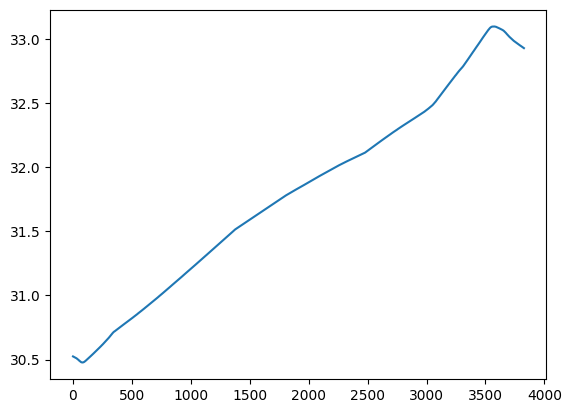

In [5]:
state_vectors['lat'].plot()